In [113]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch
from tqdm import tqdm
from typing import Tuple,List

import os
import imageio
from IPython.display import Image
import numpy as np

from dataclasses import dataclass
from matplotlib import pyplot as plt

from torch.distributions import (
    Exponential,
    Categorical, 
    Dirichlet
)

# UTILS

In [50]:
def states_at_grid(paths_batch, times, time_grid):
    """
    For a simulation of states and times, for each value of the time grid,
    assigns the state with the rightmost time to the grid time.

    :param times: torch.Tensor(batch_size,number_of_timesteps)
    :param paths_batch torch.Tensor(batch_size,number_of_timesteps,number_of_spins):
    :param time_grid: torch.Tensor(number_of_timesteps)
    :return:
    """
    if len(times.shape) == 3:
        times = times.squeeze()

    assert torch.all(times[:, 0] == 0.)
    assert time_grid[0] == 0.
    assert paths_batch.shape[:-1] == times.shape

    batch_size = paths_batch.shape[0]
    tau = time_grid[1]
    time_grid_ = time_grid + tau # arrival is to the left of the box

    x = time_grid_[None, None, :] - times[:, :, None]
    times_not_allowed = times[:, :, None] > time_grid_[None, None, :]
    x[times_not_allowed] = torch.inf
    min_indices = torch.argmin(x, axis=1)

    arrivals = times[torch.arange(batch_size)[:, None], min_indices]
    states_at_arrival = paths_batch[torch.arange(batch_size)[:, None], min_indices, :]

    return states_at_arrival,arrivals

In [51]:
def count_values_along_time(paths, num_states):
    """
    Count each integer's occurrences at each timestep along the second dimension of a tensor.

    Parameters:
        paths (torch.Tensor): A 2D tensor of shape (N, T) containing integer values.
        num_states (int): The number of distinct states (integer values).

    Returns:
        torch.Tensor: A 2D tensor of shape (T, num_states) where each row gives the counts
                      of each state at that timestep.
    """
    N, T = paths.shape
    counts = torch.zeros((T, num_states), dtype=torch.long)

    # Process each timestep
    for t in range(T):
        # Extract the data at timestep t
        timestep_data = paths[:, t]
        # Count occurrences of each state at this timestep
        for state in range(num_states):
            counts[t, state] = torch.sum(timestep_data == state)

    return counts

# Solvers

In [52]:
def gillespie(X0,Q,number_of_times=100)->Tuple[torch.Tensor,torch.Tensor]:
    """
    # http://be150.caltech.edu/2019/handouts/12_stochastic_simulation_all_code.html

    parameters
    ----------

    X0: initial conditions
    q_rate_function: function -> new_states_available,rates

    returns
    -------
    paths,times
    """
    num_states = Q.size(0)
    batch_size = X0.shape[0]

    rates_from_Q  = lambda X,Q : Q[X]
    Q_r = Q.clone()
    Q_r[range(num_states),range(num_states)] = 0

    # Initialize process
    times = torch.full((batch_size, 1), 0.)
    paths = X0.unsqueeze(1)

    for time_index in range(number_of_times):
        X = paths[:,-1]
        current_time = times[:,-1]

        # rates and probabilities
        rates = rates_from_Q(X, Q_r)
        rates_sum = -Q[X,X].squeeze() #diagonal sum to 0
        transition_probabilities = rates/rates_sum[:,None]

        #times
        time_between_events = Exponential(rates_sum).sample()
        new_times = current_time + time_between_events

        # selects next state
        new_states = Categorical(transition_probabilities).sample()

        #update paths and times
        paths = torch.concatenate([paths,
                                   new_states.unsqueeze(1)], dim=1)

        times = torch.concatenate([times,
                                   new_times.unsqueeze(1)],dim=1)
    
    return paths,times

# Simulation

In [132]:
Q1 = torch.Tensor([[-2.,2.,0.],
                   [1.,-3.,2.],
                   [0.,1.,-1.]])


number_of_states = Q1.shape[0]
zeros_ = np.zeros(number_of_states)

In [107]:
stationary = np.asarray([1./7.,2./7.,4./7.])
stationary

array([0.14285714, 0.28571429, 0.57142857])

In [141]:
number_of_paths = 3000
number_of_times = 100
time_scaling = .04

Q0 = torch.Tensor([[-2.,2.,0.],
                   [1.,-3.,2.],
                   [0.,1.,-1.]])
Q0 = Q0*time_scaling

number_of_states = Q0.shape[0]

pi0_prior = Dirichlet(torch.full((number_of_states,),100.))
pi_0 = np.asarray([1./3.,1./3.,1./3.])
X0 = Categorical(torch.Tensor(pi_0)).sample((number_of_paths,))
empirical_histogram_0 = F.one_hot(X0,number_of_states).sum(axis=0)/X0.shape[0]
paths0,times0 = gillespie(X0,Q0,number_of_times=number_of_times)

av_final_time = (times0[:,1:] - times0[:,:-1]).mean()*number_of_times
av_interevent_time = (times0[:,1:] - times0[:,:-1]).mean()

print(f"Average final time {av_final_time}")
print(f"Average Interevent {av_interevent_time}")

Average final time 1462.34765625
Average Interevent 14.6234769821167


In [142]:
# set everything in a grid
time_grid = torch.arange(0,number_of_times,1,dtype=float)
paths0_grid,arrivals0 = states_at_grid(paths0.unsqueeze(-1), times0, time_grid)

paths0_grid = paths0_grid.squeeze()

histograms_on_time_0 = count_values_along_time(paths0_grid, number_of_states)

histograms_on_time_0 = histograms_on_time_0/paths0_grid.shape[0]

hist_final = histograms_on_time_0[-1]
hist_start = histograms_on_time_0[0]

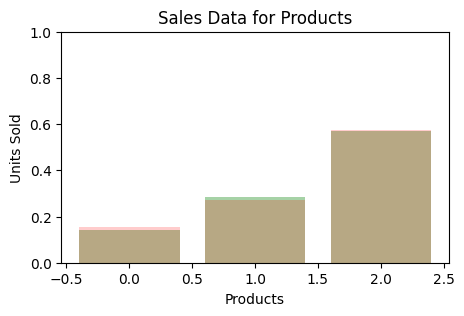

In [151]:
plt.figure(figsize=(5, 3))

plt.bar(range(len(stationary)), stationary, color='green',alpha=0.35)
#plt.bar(range(len(empirical_histogram_0)), empirical_histogram_0, color='purple',alpha=0.2)
#plt.bar(range(len(hist_start)), hist_start, color='orange',alpha=0.2)
plt.bar(range(len(hist_final)), hist_final, color='red',alpha=0.2)

plt.xlabel('Products')
plt.ylabel('Units Sold')
plt.title('Sales Data for Products')
plt.ylim(0,1)
plt.show()